In [0]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [0]:
data = pd.read_csv("https://raw.githubusercontent.com/insaid2018/Term-2/master/Data/credit_fraud.csv")

In [15]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## About the Data
To quote from Kaggle:

"The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'."

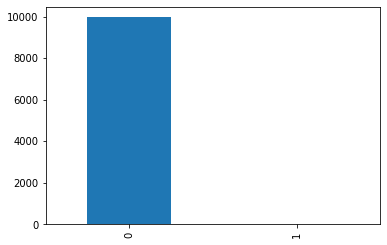

In [16]:
data['Class'].value_counts().plot.bar()

In [17]:
print('Proportion of the classes in the data:')
print(data['Class'].value_counts() / len(data))

Proportion of the classes in the data:
0    0.9962
1    0.0038
Name: Class, dtype: float64


We will build a simple logistic regression classifer and compare the results for the classifier without SMOTE to with SMOTE.

In [0]:
data = data.drop(['Time'], axis = 1)
X = np.array(data.loc[:, data.columns != 'Class'])
y = np.array(data.loc[:, data.columns == 'Class']).reshape(-1, 1)

In [0]:
# standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [0]:
# split into training and testing datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 2, shuffle = True, stratify = y)



In [0]:
# import logistic regression model and accuracy_score metric
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
clf = LogisticRegression()

# Without SMOTE

In [0]:
# fit the model
clf.fit(X_train, y_train.ravel())

# prediction for training dataset
train_pred = clf.predict(X_train)

# prediction for testing dataset
test_pred = clf.predict(X_test)

In [23]:
print('Accuracy score for Training Dataset = ', accuracy_score(train_pred, y_train))
print('Accuracy score for Testing Dataset = ', accuracy_score(test_pred, y_test))

Accuracy score for Training Dataset =  1.0
Accuracy score for Testing Dataset =  0.9990909090909091


Wow! Such high accuracies!

You might think that the model has performed exceptionally well. Well, that's not the case. Let us examine the confusion matrix for our predictions.

In [24]:
print('Confusion Matrix - Training Dataset')
print(pd.crosstab(y_train.ravel(), train_pred, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Training Dataset
Predicted     0   1   All
True                     
0          6675   0  6675
1             0  25    25
All        6675  25  6700


Now let's interpret the results. 

134 out of 330 instances which belong to class 1 have been classifed as class 0.

In [25]:
134/330

0.40606060606060607

That is a whopping 41%! We are classifying 41% of the <b>fraud</b> cases as <b>not fraud</b>. This is going to cost some serious losses to the credit card company. You can observe this similarly in the confusion matrix of the Testing Dataset.

The higher accuracy is not due to correct classification. The model has predicted the majority class for almost all the examples. And since about 99.8% of the examples actually belong to this class, it leads to such high accuracy scores.

In [26]:
print('Confusion Matrix - Testing Dataset')
print(pd.crosstab(y_test.ravel(), test_pred.ravel(), rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Testing Dataset
Predicted     0   1   All
True                     
0          3287   0  3287
1             3  10    13
All        3290  10  3300


55 out of 162 instances which belong to class 1 have been classifed as class 0. We are missing about 34% of the fraud cases.

# Using SMOTE
Researchers have found that balancing the data will to better classification models. We will try balancing our data using SMOTE.

In [0]:
# !pip install -q imblearn

In [0]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

In [0]:
X_train_new, y_train_new = sm.fit_sample(X_train, y_train.ravel())

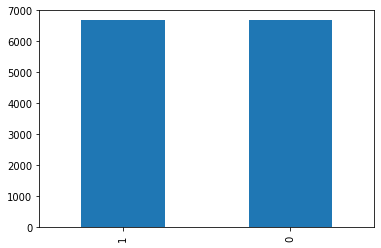

In [30]:
# observe that data has been balanced
pd.Series(y_train_new).value_counts().plot.bar()

In [0]:
# fit the model
clf.fit(X_train_new, y_train_new)

# prediction for Training data
train_pred_sm = clf.predict(X_train_new)

# prediction for Testing data
test_pred_sm = clf.predict(X_test)

In [32]:
print('Accuracy score for Training Dataset = ', accuracy_score(train_pred_sm, y_train_new))
print('Accuracy score for Testing Dataset = ', accuracy_score(test_pred_sm, y_test))

Accuracy score for Training Dataset =  1.0
Accuracy score for Testing Dataset =  0.9990909090909091


Our accuracy has reduced. But our model has definitely improved. Observe the confusion matrices.

In [33]:
print('Confusion Matrix - Training Dataset')
print(pd.crosstab(y_train_new, train_pred_sm, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Training Dataset
Predicted     0     1    All
True                        
0          6675     0   6675
1             0  6675   6675
All        6675  6675  13350


In [34]:
16685/190490

0.08758989973226941

16685 out of 190490 <b>fraud</b> cases have been classified as <b>not fraud</b>. This is a mere 8.7% compared to the previous 41%.

A vast improvement!

Same is the case with the Testing Dataset.

In [35]:
print('Confusion Matrix - Testing Dataset')
print(pd.crosstab(y_test.ravel(), test_pred_sm, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Testing Dataset
Predicted     0   1   All
True                     
0          3287   0  3287
1             3  10    13
All        3290  10  3300


In [36]:
12/162

0.07407407407407407

Roughly 7.4% of the fraud classes have been classified as not fraud.

# Conclusion
One might argue that the reduced accuracy is an indicator of lower model performance. However, this is not true.

Error in prediction can be made in two ways:
1. Classifying <b>not fraud</b> as <b>fraud</b>
2. Classifying <b>fraud</b> as <b>not fraud</b>

It should not be hard to understand that the second error is costlier than the first.

The objective of each classification problem is different. So make sure to evaluate each model with respect to its own objective instead of merely judging it on its accuracy.